In [1]:
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [10]:
def load_emails(path, email_type):
    rows = []
    for email in os.listdir(path):
        content = Path(path, email).read_text(encoding='latin-1')
        contents = {'Type': email_type, 'Content': content}
        rows.append(contents)
        
    return pd.DataFrame(rows, columns=['Type', 'Content'])
    
hard_ham = load_emails('hard_ham/', 'ham')
easy_ham = load_emails('easy_ham/', 'ham')
spam = load_emails('spam/', 'spam')

print('hard ham: ', len(hard_ham))
print('easy ham: ', len(easy_ham))
print('spam: ', len(spam))

hard ham:  250
easy ham:  2551
spam:  501


In [7]:
def bayes(X_train, X_test, Y_trainlabel, Y_testlabel, filter_words=None):
    vectorizer = CountVectorizer(stop_words=filter_words, encoding='latin-1')
    X_train_count = vectorizer.fit_transform(X_train)
    X_test_count = vectorizer.transform(X_test)

    # 1. Multinomial Naive Bayes - discrete data. Total Count
    multinomial_model = MultinomialNB()
    multinomial_model.fit(X_train_count, Y_trainlabel)
    multinomial_pred = multinomial_model.predict(X_test_count)

    # 2. Bernoulli Naive Bayes - binary
    vectorizer = CountVectorizer(stop_words=filter_words, encoding='latin-1', binary=True)
    X_train_count = vectorizer.fit_transform(X_train)
    X_test_count = vectorizer.transform(X_test)
    bernoulli_model = BernoulliNB()
    bernoulli_model.fit(X_train_count, Y_trainlabel)
    bernoulli_pred = bernoulli_model.predict(X_test_count)

    multinomial_cm = metrics.confusion_matrix(Y_testlabel, multinomial_pred)
    bernoulli_cm = metrics.confusion_matrix(Y_testlabel, bernoulli_pred)
    
    mTN = multinomial_cm[0][0]
    mFN = multinomial_cm[1][0]
    mTP = multinomial_cm[1][1]
    mFP = multinomial_cm[0][1]
    
    bTN = bernoulli_cm[0][0]
    bFN = bernoulli_cm[1][0]
    bTP = bernoulli_cm[1][1]
    bFP = bernoulli_cm[0][1]
    
    # Make subplots
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    labels=['Spam', 'Not Spam']
    
    sns.heatmap(multinomial_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax[0])
    ax[0].set_ylabel('Predicted')
    ax[0].set_xlabel('Actual')
    ax[0].set_title('Multinomial')
    
    sns.heatmap(bernoulli_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax[1])
    ax[1].set_ylabel('Predicted')
    ax[1].set_xlabel('Actual')
    ax[1].set_title('Bernoulli')
    
    # Scores TPR = TP/TP+FN, TNR = TN/FP+TN
    print('Multinomial %: ', accuracy_score(Y_testlabel, multinomial_pred))
    print('True Spam: ', "{:.2f}".format(mTP /(mFP+mTP)))
    print('True Ham: ', "{:.2f}".format(mTN /(mTN+mFN)))
    
    print('Bernoulli %: ', accuracy_score(Y_testlabel, bernoulli_pred)) 
    print('True Spam: ', "{:.2f}".format(bTP /(bFP+bTP)))
    print('True Ham: ', "{:.2f}".format(bTN /(bTN+bFN)))

NameError: name 'accuracy_score' is not defined

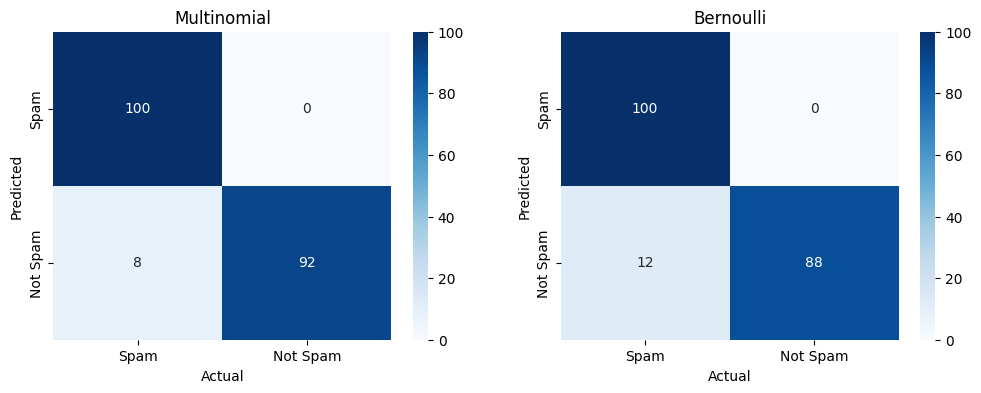

In [9]:
easy_ham_sampled = easy_ham.sample(501)

spam_train = spam.sample(frac = 0.8,random_state=25)
spam_test = spam.drop(spam_train.index,axis = 0)

ham_train = easy_ham_sampled.sample(frac = 0.8,random_state=25)
ham_test = easy_ham_sampled.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Content
X_test = X_test.Content

bayes(X_train, X_test, Y_trainlabel, Y_testlabel)